## Problem statement



To predict churning out customers 

We are going to implement the RandomForestClassifier to customer churn dataset and interpret churning 


## Load the dataset

In [30]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix

In [31]:
churn_data=pd.read_csv('churn.csv')

In [32]:
churn_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [33]:
churn_data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

Converting the Total charges column to numeric,because as you can see its original dtype is object but data is numeric

In [34]:
churn_data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [35]:
churn_data['TotalCharges']=pd.to_numeric(churn_data['TotalCharges'], errors='coerce')

In [36]:
churn_data['TotalCharges']

0         29.85
1       1889.50
2        108.15
3       1840.75
4        151.65
         ...   
7038    1990.50
7039    7362.90
7040     346.45
7041     306.60
7042    6844.50
Name: TotalCharges, Length: 7043, dtype: float64

## Missing Value Analysis

In [37]:
churn_data.isna().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

As we can see from above output Total charges is having 11 null values ,as we don't have a appropriate TotalCharges we will be dropping the 11 null value rows in the same data table or you can handel this missing values by using mean() value

In [38]:
churn_data.dropna(inplace=True)
#churn_data['TotalCharges']=churn_data['TotalCharges'].fillna(churn_data['TotalCharges'].mean())

In [39]:
churn_data.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

As CustomerId is nowhere helping in the prediction and also it's values are not appropriate to fit in the model we will be droping the Customer ID column

In [40]:
churn_data.drop(columns = ['customerID'],inplace = True)

In [41]:
churn_data.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


## Feature Selection

We are going to implement chi-square test to select the irrelevant features


Chi-Square test is normally done on Categorical data(object) ,where we will select each independent attribute and calculating chi-Square statistics value with the help of  observed value and expected value. 

if observed and expected values are close then we'll have high chi-square statistics.(high chi-square stats implies attributes are highly independent)
if observed and expected values are far then we'll have less chi-square statistics.(less chi-square stats implies attributes are  not independent)

With the above concept we'll set null and alternative hypothesis and check for its acceptance or rejection through p-value and alpha value (significance value)

if p -value > alpha value ,we reject null hypothesis
if p-value  < alpha value ,we accept null hypothesis

In [42]:
from scipy.stats import chisquare
import scipy.stats
from scipy.stats import chi2
#from scipy import stats
from scipy.stats import chi2_contingency


In [43]:
###Chisq Test for Independence for all object fields
col_list = list(churn_data.columns)
col_list.remove('Churn')
df=pd.DataFrame(columns=['Feature','P-value'])

for col in col_list:
    if churn_data[[col]][col].dtype == 'object': 

        ###Chisq Test for Independence
        dataset_table=pd.crosstab(churn_data[col],churn_data['Churn'])
        #print(dataset_table)


        #Observed Values
        Observed_Values = dataset_table.values 
        #print("Observed Values :-\n",Observed_Values)

        val=chi2_contingency(dataset_table)
        #val

        Expected_Values=val[3]
        #Expected_Values

        chi_square=sum([(o-e)**2./e for o,e in zip(Observed_Values,Expected_Values)])
        chi_square_statistic=chi_square[0]+chi_square[1]

        no_of_rows=len(dataset_table.iloc[0:2,0])
        no_of_columns=len(dataset_table.iloc[0,0:2])
        ddof=(no_of_rows-1)*(no_of_columns-1)
        #print("Degree of Freedom:-",ddof)
        alpha = 0.05
        #print("chi-square statistic:-",chi_square_statistic)
        #scipy.stats.chi2.ppf() function

        critical_value=scipy.stats.chi2.ppf(q=1-alpha,df=ddof)
        #print('critical_value:',critical_value)

        #p-value
        p_value=1-chi2.cdf(x=chi_square_statistic,df=ddof)
        #print(col)
        #print('p-value:',p_value)
        df=df.append({'Feature':col, 'P-value': p_value}, ignore_index=True)
        #print('Significance level: ',alpha)
        #print('Degree of Freedom: ',ddof)
        #print('p-value:',p_value)
        #df.append()
df

,Feature,P-value
0,gender,0.473665
1,Partner,0.000000
2,Dependents,0.000000
3,PhoneService,0.326886
4,MultipleLines,0.000787
5,InternetService,0.000000
6,OnlineSecurity,0.000000
7,OnlineBackup,0.000000
8,DeviceProtection,0.000000
9,TechSupport,0.000000


From the above output as p value for gender and phone service is greater than critical value ,we'll be dropping those columns and only considering the relevant columns

In [44]:
churn_data.drop(columns = ['gender'],inplace = True)

In [45]:
churn_data.drop(columns = ['PhoneService'],inplace = True)

In [46]:
churn_data.columns

Index(['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges',
       'Churn'],
      dtype='object')

from the above feature selection technique we have selected only a relveant columns and removed the irrelavant columns

So columns before

['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
     
in total 22 columns
    
Columns after chi-square analysis

['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'MultipleLines',
'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges',
'Churn']

reduced to 19 columns

2 irrelvant columns  are dropped ['gender','phone service'] and 'customer_id ' is dropped because customer_id datatype will give error while fitting the data,

## Label Encoding

Encoding all the labels as numerical categories as because this kinds of string data cannot be used to fit as these are incompatible type to fit the classification model

this can be performed through label_encoder() or using the map() function.

In [47]:


churn_data['Partner'] = churn_data['Partner'].map({'Yes': 1, 'No': 0})
churn_data['Dependents'] = churn_data['Dependents'].map({'Yes': 1, 'No': 0})
churn_data['MultipleLines']=churn_data['MultipleLines'].map({'No phone service':0, 'No': 1, "Yes": 2})
churn_data['InternetService']=churn_data['InternetService'].map({'DSL':0, 'Fiber optic':1, 'No':2})
churn_data['OnlineSecurity']=churn_data['OnlineSecurity'].map({'Yes':1, 'No':0, 'No internet service':2})
churn_data['OnlineBackup']=churn_data['OnlineBackup'].map({'Yes':1, 'No':0, 'No internet service':2})
churn_data['DeviceProtection']=churn_data['DeviceProtection'].map({'Yes':1, 'No':0, 'No internet service':2})
churn_data['TechSupport']=churn_data['TechSupport'].map({'Yes':1, 'No':0, 'No internet service':2})
churn_data['StreamingTV']=churn_data['StreamingTV'].map({'Yes':1, 'No':0, 'No internet service':2})
churn_data['StreamingMovies']=churn_data['StreamingMovies'].map({'Yes':1, 'No':0, 'No internet service':2})
churn_data['Contract']=churn_data['Contract'].map({'Month-to-month':0, 'One year':1, 'Two year':2})
churn_data['PaperlessBilling']=churn_data['PaperlessBilling'].map({'Yes':1, 'No':0})
churn_data['PaymentMethod']=churn_data['PaymentMethod'].map({'Electronic check':1, 'Mailed check':0, 'Bank transfer (automatic)':2, 'Credit card (automatic)':3})


In [48]:
# OR YOU CAN USE THIS METHOD
# col_list= ['Partner', 'Dependents', 'tenure', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
# from sklearn.preprocessing import LabelEncoder
# labelencoder = LabelEncoder()
# for i in col_list:
#     churn_data[i]=labelencoder.fit_transform(churn_data[i])

In [49]:
churn_data

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,29.85,29.85,No
1,0,0,0,34,1,0,1,0,1,0,0,0,1,0,0,56.95,1889.50,No
2,0,0,0,2,1,0,1,1,0,0,0,0,0,1,0,53.85,108.15,Yes
3,0,0,0,45,0,0,1,0,1,1,0,0,1,0,2,42.30,1840.75,No
4,0,0,0,2,1,1,0,0,0,0,0,0,0,1,1,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,1,1,24,2,0,1,0,1,1,1,1,1,1,0,84.80,1990.50,No
7039,0,1,1,72,2,1,0,1,1,0,1,1,1,1,3,103.20,7362.90,No
7040,0,1,1,11,0,0,1,0,0,0,0,0,0,1,1,29.60,346.45,No
7041,1,1,0,4,2,1,0,0,0,0,0,0,0,1,0,74.40,306.60,Yes


In [50]:
churn_data.dtypes

SeniorCitizen         int64
Partner               int64
Dependents            int64
tenure                int64
MultipleLines         int64
InternetService       int64
OnlineSecurity        int64
OnlineBackup          int64
DeviceProtection      int64
TechSupport           int64
StreamingTV           int64
StreamingMovies       int64
Contract              int64
PaperlessBilling      int64
PaymentMethod         int64
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

So now after encoding you can check that the dtypes of all the data is numerical where this data fits into any classification probelm perfecty

## Data Visualization

###### 1

Starting with visualizing how many customers have churned out and how many are still in contract with the company

<IPython.core.display.Javascript object>

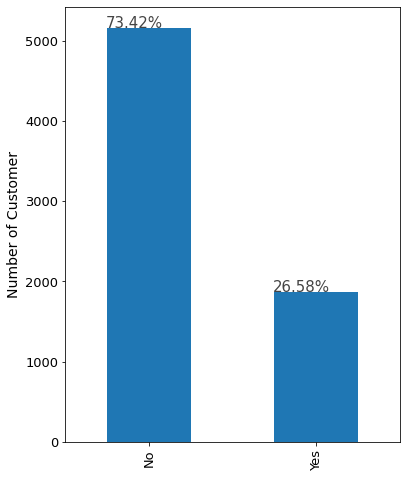

In [51]:
ax = churn_data["Churn"].value_counts().plot(kind='bar', figsize=(6, 8), fontsize=13)
ax.set_ylabel("Number of Customer", fontsize=14);

totals = []
for i in ax.patches:
    totals.append(i.get_height())

total = sum(totals)

for i in ax.patches:
    ax.text(i.get_x() - .01, i.get_height() + .5, \
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=15,
                color='#444444')
plt.show()

from the above visualization its  clear that 26.58 % of people have churned out and 73.43% people have not churned.

##### 2

1st scatter plot

from this 1st scatter plot we can infer that , more the  tatal charge ,and higher the tenure, less the churning rate

because as from visualization the more people are churned out are the one's with less total charge and less tenure 


2nd  scatter plot

from this 2nd scatter plot we can infer that , more the  montly charge ,and higher the tenure, less the churning rate.

because as from visualization the more people are churned out are the one's with less mothly charge and less tenure 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='MonthlyCharges', ylabel='tenure'>

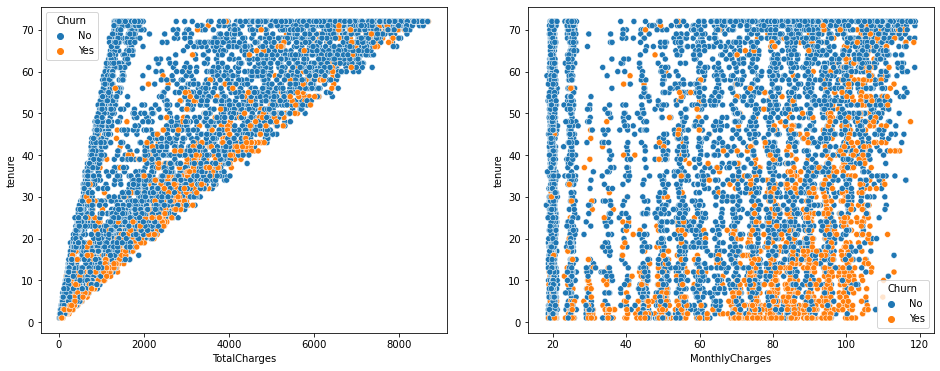

In [52]:
_, ax = plt.subplots(1, 2, figsize= (16, 6))
sns.scatterplot(x="TotalCharges", y = "tenure" , hue="Churn", data=churn_data, ax=ax[0])
sns.scatterplot(x="MonthlyCharges", y = "tenure" , hue="Churn", data=churn_data, ax=ax[1])

##### 3

there is same inference with Facetgrid also.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

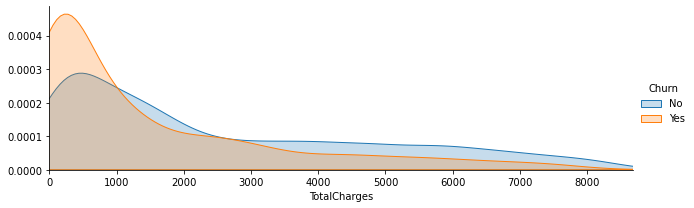

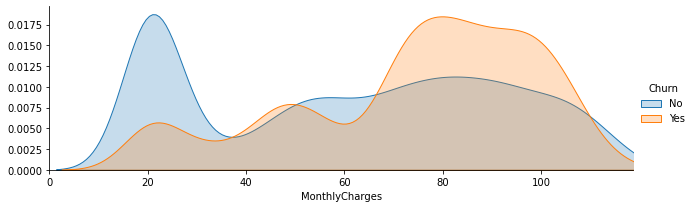

In [53]:
facet = sns.FacetGrid(churn_data, hue = "Churn", aspect = 3)
facet.map(sns.kdeplot,"TotalCharges",shade= True)
facet.set(xlim=(0, churn_data["TotalCharges"].max()))
facet.add_legend()

facet = sns.FacetGrid(churn_data, hue = "Churn", aspect = 3)
facet.map(sns.kdeplot,"MonthlyCharges",shade= True)
facet.set(xlim=(0, churn_data["MonthlyCharges"].max()))
facet.add_legend()

##### 4

from the below heatmap we can check the correlation between the features

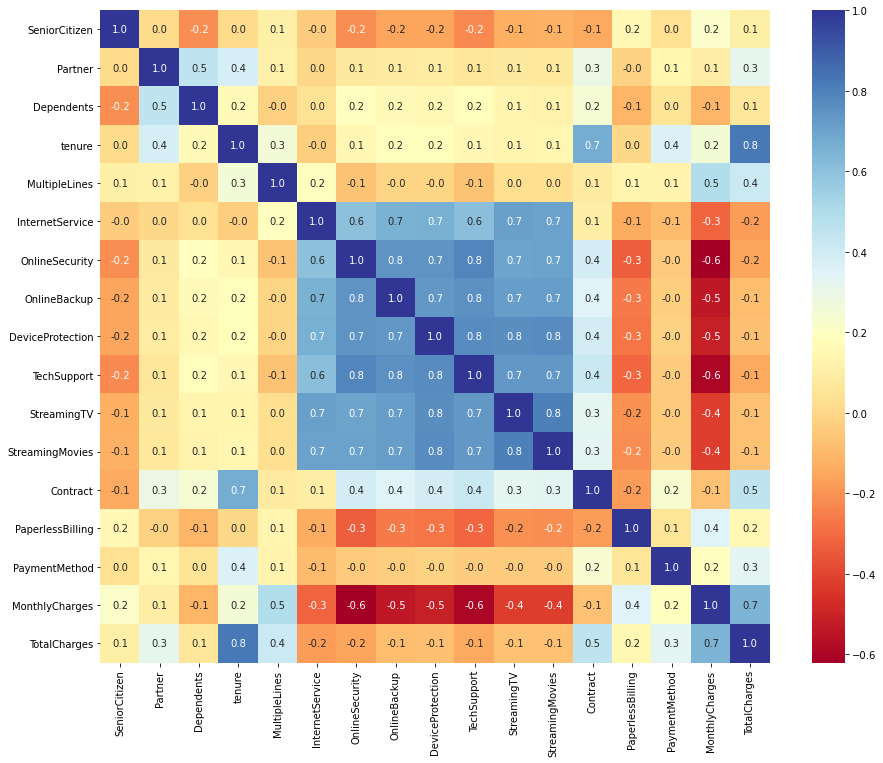

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (15, 12))
sns.heatmap(churn_data.corr(), cmap="RdYlBu", annot=True, fmt=".1f")
plt.show()

we can infer that there are hightly_corr_feature = ["OnlineBackup_No internet service", "StreamingMovies_No internet service", "StreamingTV_No internet service", "TechSupport_No internet service", "DeviceProtection_No internet service", "OnlineSecurity_No internet service"]

# Model building 

Firstly we'll map the churn column with 1 and 0 instead od 0yes and no so that all the features and label  will have uniform datatype

In [55]:
churn_data['Churn'] = churn_data['Churn'].map({'Yes': 1, 'No': 0})

As our main prediction is to check the churning out customers ,so we consider churn as depended data and all other features are considered as independent (features after feature selection)

In [56]:
X = churn_data.iloc[:, :-1].values
y = churn_data.iloc[:, -1].values

Splitting the data into train and test data ,as training data will be used for training the model and test data is for prediction.

In [57]:
x_train, x_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=0)

Now we will fit the data into RandomForestClassifier ,As random forest is  ensemble method .we will be importing RandomForestClassifier from sklearn's ensemble library

In [58]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state = 42)



In [59]:
rf1=rf.fit(x_train,y_train) 

Checking for prediction for the above fit model

In [60]:
y_pred=rf1.predict(x_test)

From the prediction result(predicted values) and test value(actual value ) we'll check the model efficiency

In [61]:
from sklearn.metrics import accuracy_score
accuracy_score(y_pred,y_test)

0.7839374555792467

from the above accuracy we can infer that the model is having 78.39% accuracy that is out of 100 predictions we'll be getting 78 predictions as true prediction

# Hyper parameter tuning

**Hyper-parameters**  are parameters that define the model structure, and **tuning** hyper-parameters is the process of finding the best model structure. So that model  structure makes the model more efficient

There are many parameters which we can look into while building the randomforest model they are:

**bootstrap'/max_sample:** The max_samples hyperparameter determines what fraction of the original dataset is given to any individual tree

**'max_depth':** The max_depth of a tree in Random Forest is defined as the longest path between the root node and the leaf node

**'max_features':** This resembles the number of maximum features provided to each tree in a random forest. 

**'min_samples_leaf':** This Random Forest hyperparameter specifies the minimum number of samples that should be present in the leaf node after splitting a node.

**'min_samples_split':** parameter that tells the decision tree in a random forest the minimum required number of observations in any given node in order to split it. 

**'n_estimators':**
number of decision trees to choose while fitting the random forest model

There are two techniques for hyper parameter tuning :
    1.RandomizedSearchCV
    2.GridSearchCV
    
For our model we will be implementing  RandomizedSearchCV method and tune our model

So we'll select the best values for each parameter ,below code help's  us to extract the best values for each parameter

In [62]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

NameError: name 'pprint' is not defined

Steps to implement:
    

1.Use the random grid to search for best hyperparameters
2.First create the base model to tune
3.Random search of parameters, using 3 fold cross validation
4.search across 100 different combinations, and use all available cores
5.Fit the random search model

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(random_state = 42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 100, scoring='neg_mean_absolute_error', 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rf2=rf_random.fit(x_train, y_train);

from the above fitted model you can check the best values for each parameter across 10o folds

In [ ]:
rf2.best_params_

So after hyperparameter tuning ,we have fitted the model with best parameters and the best value.

lets check the predictions for the model fitted after tuning

In [ ]:
y_pred=rf2.predict(x_test)

So from the below outup we can see there is a 1.28% change in accuracy .

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_pred,y_test)

after implementation of  hyper parameter tuning to the model, we can see that there is increase in performance of the model

In [ ]:
rf2.cv_results_

# Model Evaluation

We'll check the feature importance of the fitted model .where feature importance helps the contribution of each and every features for the built model

In [ ]:
importance = rf1.feature_importances_

In [ ]:
importance= pd.Series(importance)
importance

In [ ]:
df=pd.DataFrame(columns=['Feature','Importance'])

In [ ]:
df

In [ ]:

col_list.remove('gender')
col_list.remove('PhoneService')

In [ ]:
col_list

In [ ]:
df['Feature']=col_list

In [ ]:
df

In [ ]:
df['Importance']=importance

In [ ]:
df

In [ ]:
df.sort_values(by='Importance', ascending=False)

In [ ]:
import seaborn as sns 
import matplotlib.pyplot as plt
plt.figure(figsize=(25,6))
# make barplot and sort bars
sns.barplot(x='Feature',y="Importance",data=df, order=df.sort_values('Importance', ascending=False).Feature)

From the above  plot we can infer that there is only few colums which have more contribution for prediction

#### predict proba

predict_proba gives you the probabilities for the target (0 and 1 in our  case) in array form. The number of probabilities for each row is equal to the number of categories in target variable (2 in your case)

In [ ]:
proba_valid = rf2.predict_proba(x_test)[:, 1]

In [ ]:
proba_valid

##### roc

In [ ]:
from sklearn.metrics import roc_auc_score

It is a probability curve that plots the TPR against FPR at various threshold values and essentially separates the ‘signal’ from the ‘noise’. The Area Under the Curve (AUC) is the measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve.

The higher the AUC, the better the performance of the model at distinguishing between the positive and negative classes.

When AUC = 1, then the classifier is able to perfectly distinguish between all the Positive and the Negative class points correctly. If, however, the AUC had been 0, then the classifier would be predicting all Negatives as Positives, and all Positives as Negatives.


When 0.5<AUC<1, there is a high chance that the classifier will be able to distinguish the positive class values from the negative class values. This is so because the classifier is able to detect more numbers of True positives and True negatives than False negatives and False positives.


When AUC=0.5, then the classifier is not able to distinguish between Positive and Negative class points. Meaning either the classifier is predicting random class or constant class for all the data points.

So, the higher the AUC value for a classifier, the better its ability to distinguish between positive and negative classes.



In a ROC curve, a higher X-axis value indicates a higher number of False positives than True negatives. While a higher Y-axis value indicates a higher number of True positives than False negatives. So, the choice of the threshold depends on the ability to balance between False positives and False negatives.

In [ ]:
roc_auc_score(y_test, proba_valid)

In [ ]:
col_list = list(churn_data.columns)

In [ ]:
col_list

In [ ]:
col_list.remove('Churn')

In [ ]:
col_list

In [ ]:
df_new=pd.DataFrame({'Predictions':y_pred})

In [ ]:
df_new

In [ ]:
df_new.insert(1, "Y_predict_proba", proba_valid)

In [ ]:
df_new

In [ ]:
df_new.isna().sum()

In [ ]:
df_new['Y_pred_0.1']=np.where((df_new['Y_predict_proba']>0.1), 1,0)
df_new['Y_pred_0.2']=np.where(df_new['Y_predict_proba']>0.2,1,0)
df_new['Y_pred_0.3']=np.where(df_new['Y_predict_proba']>0.3, 1,0)
df_new['Y_pred_0.4']=np.where(df_new['Y_predict_proba']>0.4, 1,0)
df_new['Y_pred_0.5']=np.where(df_new['Y_predict_proba']>0.5, 1,0)
df_new['Y_pred_0.6']=np.where(df_new['Y_predict_proba']>0.6, 1,0)
df_new['Y_pred_0.7']=np.where(df_new['Y_predict_proba']>0.7, 1,0)
df_new['Y_pred_0.8']=np.where(df_new['Y_predict_proba']>0.8, 1,0)
df_new['Y_pred_0.9']=np.where(df_new['Y_predict_proba']>0.9, 1,0)

In [ ]:
df_new

In [ ]:
df_new

In [ ]:
#df_new['Predictions'] = df_new['Predictions'].map({1: 'Yes', 0: 'No'})

In [ ]:
df_new#0.5 as cutoff
#label predictions

In [ ]:
confusion_matrix(df_new['Predictions'],df_new['Y_pred_0.1'])

In [ ]:
c1=confusion_matrix(df_new.loc[:,'Predictions'],df_new.loc[:,'Y_pred_0.1'])
c2=confusion_matrix(df_new.loc[:,'Predictions'],df_new.loc[:,'Y_pred_0.2'])
c3=confusion_matrix(df_new.loc[:,'Predictions'],df_new.loc[:,'Y_pred_0.3'])
c4=confusion_matrix(df_new.loc[:,'Predictions'],df_new.loc[:,'Y_pred_0.4'])
c5=confusion_matrix(df_new.loc[:,'Predictions'],df_new.loc[:,'Y_pred_0.5'])
c6=confusion_matrix(df_new.loc[:,'Predictions'],df_new.loc[:,'Y_pred_0.6'])
c7=confusion_matrix(df_new.loc[:,'Predictions'],df_new.loc[:,'Y_pred_0.7'])
c8=confusion_matrix(df_new.loc[:,'Predictions'],df_new.loc[:,'Y_pred_0.8'])
c9=confusion_matrix(df_new.loc[:,'Predictions'],df_new.loc[:,'Y_pred_0.9'])


In [ ]:
sen1=c1[0,0]/(c1[0,0]+c1[0,1])
sen2=c2[0,0]/(c2[0,0]+c2[0,1])
sen3=c3[0,0]/(c3[0,0]+c3[0,1])
sen4=c4[0,0]/(c4[0,0]+c4[0,1])
sen5=c5[0,0]/(c5[0,0]+c5[0,1])
sen6=c6[0,0]/(c6[0,0]+c6[0,1])
sen7=c7[0,0]/(c7[0,0]+c7[0,1])
sen8=c8[0,0]/(c8[0,0]+c8[0,1])
sen9=c9[0,0]/(c9[0,0]+c9[0,1])


In [ ]:
sep1=c1[1,1]/(c1[1,1]+c1[1,0])
sep2=c2[1,1]/(c2[1,1]+c2[1,0])
sep3=c3[1,1]/(c3[1,1]+c3[1,0])
sep4=c4[1,1]/(c4[1,1]+c4[1,0])
sep5=c5[1,1]/(c5[1,1]+c5[1,0])
sep6=c6[1,1]/(c6[1,1]+c6[1,0])
sep7=c7[1,1]/(c7[1,1]+c7[1,0])
sep8=c8[1,1]/(c8[1,1]+c8[1,0])
sep9=c9[1,1]/(c9[1,1]+c9[1,0])


In [ ]:
d_cutoff_value=pd.DataFrame(columns=['cutoff','Sensitivity','Specificity'])

In [ ]:
d_cutoff_value=d_cutoff_value.append({'cutoff':0.1, 'Sensitivity': sen1,'Specificity':sep1}, ignore_index=True)
d_cutoff_value=d_cutoff_value.append({'cutoff':0.2, 'Sensitivity': sen2,'Specificity':sep2}, ignore_index=True)
d_cutoff_value=d_cutoff_value.append({'cutoff':0.3, 'Sensitivity': sen3,'Specificity':sep3}, ignore_index=True)
d_cutoff_value=d_cutoff_value.append({'cutoff':0.4, 'Sensitivity': sen4,'Specificity':sep4}, ignore_index=True)
d_cutoff_value=d_cutoff_value.append({'cutoff':0.5, 'Sensitivity': sen5,'Specificity':sep5}, ignore_index=True)
d_cutoff_value=d_cutoff_value.append({'cutoff':0.6, 'Sensitivity': sen6,'Specificity':sep6}, ignore_index=True)
d_cutoff_value=d_cutoff_value.append({'cutoff':0.7, 'Sensitivity': sen7,'Specificity':sep7}, ignore_index=True)
d_cutoff_value=d_cutoff_value.append({'cutoff':0.8, 'Sensitivity': sen8,'Specificity':sep8}, ignore_index=True)
d_cutoff_value=d_cutoff_value.append({'cutoff':0.9, 'Sensitivity': sen9,'Specificity':sep9}, ignore_index=True)

In [ ]:
d_cutoff_value

In [ ]:
for i in range(9):
    
    d_cutoff_value.loc[i,'Total_val']=d_cutoff_value.loc[i,'Sensitivity']+d_cutoff_value.loc[i,'Specificity']

In [ ]:
d_cutoff_value

In [ ]:
test_pred_prob = rf2.predict_proba(x_test)
test_pred_prob

##### roc curve

It is a probability curve that plots the TPR against FPR at various threshold values and essentially separates the ‘signal’ from the ‘noise’. The Area Under the Curve (AUC) is the measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve.

The higher the AUC, the better the performance of the model at distinguishing between the positive and negative classes.

When AUC = 1, then the classifier is able to perfectly distinguish between all the Positive and the Negative class points correctly. If, however, the AUC had been 0, then the classifier would be predicting all Negatives as Positives, and all Positives as Negatives.


When 0.5<AUC<1, there is a high chance that the classifier will be able to distinguish the positive class values from the negative class values. This is so because the classifier is able to detect more numbers of True positives and True negatives than False negatives and False positives.


When AUC=0.5, then the classifier is not able to distinguish between Positive and Negative class points. Meaning either the classifier is predicting random class or constant class for all the data points.

So, the higher the AUC value for a classifier, the better its ability to distinguish between positive and negative classes.



In a ROC curve, a higher X-axis value indicates a higher number of False positives than True negatives. While a higher Y-axis value indicates a higher number of True positives than False negatives. So, the choice of the threshold depends on the ability to balance between False positives and False negatives.

In [ ]:
#roc curve

# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# calculate scores
auc = roc_auc_score(np.array(y_test), test_pred_prob[:, 1])

# summarize scores

print('Logistic: ROC AUC=%.3f' % (auc))

# calculate roc curves

fpr, tpr, _ = roc_curve(np.array(y_test), test_pred_prob[:, 1])
# plot the roc curve for the model

pyplot.plot(fpr, tpr, marker='.', label='Random')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()


In [ ]:
df_pred_final=pd.DataFrame(columns=['Actual_churn','Pred_for_0.5_cutoff','Label'])

In [ ]:
df_pred_final['Actual_churn']=y_test

In [ ]:
df_pred_final

In [ ]:
df_pred_final['Pred_for_0.5_cutoff']=df_new['Y_pred_0.5']

In [ ]:
df_pred_final

In [ ]:
for i in range(1407):
    if(df_pred_final.loc[i,'Actual_churn']==1 and df_pred_final.loc[i,'Pred_for_0.5_cutoff']==1):
        df_pred_final.loc[i,'Label']='TP'
    elif(df_pred_final.loc[i,'Actual_churn']==0 and df_pred_final.loc[i,'Pred_for_0.5_cutoff']==1):
        df_pred_final.loc[i,'Label']='FP'
    elif(df_pred_final.loc[i,'Actual_churn']==1 and df_pred_final.loc[i,'Pred_for_0.5_cutoff']==0):
        df_pred_final.loc[i,'Label']='FN'
    elif(df_pred_final.loc[i,'Actual_churn']==0 and df_pred_final.loc[i,'Pred_for_0.5_cutoff']==0):
        df_pred_final.loc[i,'Label']='TN'

In [ ]:
df_pred_final

In [ ]:
#getting count of TP labels
df_pred_final[df_pred_final['Label']=='TP'].shape

### classification_report


classification_report helps us to evaluate the model

There are four ways to check the predictions
True Negative: the case was negative and predicted negative
True Positive: the case was positive and predicted positive
False Negative: the case was positive but predicted negative
False Positive: the case was negative but predicted positive
    
    
    
Precision:- Accuracy of positive predictions.
Precision = TP/(TP + FP)

Recall:- Fraction of positives that were correctly identified.
Recall = TP/(TP+FN)


F1 score:- What percent of positive predictions were correct
F1 score = 2*(Recall * Precision) / (Recall + Precision)

Support:-Support is the number of actual occurrences of the class in the specified dataset

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(df_pred_final['Actual_churn'], df_pred_final['Pred_for_0.5_cutoff']))

so from classification_report we can evaluate the model performence in micro level